In [27]:
from epi_model import *

In [28]:
from frozendict import frozendict as fzd

In [29]:
dfs, modelsets = {},{}

In [30]:
names = [
    'HS1_expand300',
    'HS2',
    'synthetic_3'
]

In [31]:
def get_bounds(l, q, z=1.96):
    l = sorted(l)
    n = len(l)

    i = int( np.ceil( n*q - z*np.sqrt(n*q*(1-q)) ) )
    j = int( np.ceil( n*q + z*np.sqrt(n*q*(1-q)) ) )

    return (l[i], l[j])

def none_info(k):
    d = dict(k)
    d['strat'] = 'none'
    d = fzd(d)
    return info(d)

def rand_info(k):
    d = dict(k)
    d['strat'] = 'rand'
    d = fzd(d)
    return info(d)

def info(k):
    row = {}
    
    ninf = [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]
    
    for kk,vv in k.items():
        row[kk] = vv

    row['mean'] = np.mean( ninf )
    row['std'] = np.std( ninf )
    row['stderr'] = np.std( ninf ) / np.sqrt( len(ninf) )
    row['Nsims'] = len(ninf)

    for Q in [25, 50, 75]:
        row[f'{Q}p'] = np.quantile( ninf, Q/100 )
        row[f'{Q}pL95'], row[f'{Q}pH95'] = get_bounds( ninf, Q/100 )

    row[f'min'] = np.min(ninf)
    row[f'max'] = np.max(ninf)
    
    row['Nn'] = list(models[k])[0]['numNodes'] # assuming constant

    if k['strat'] != 'none':
        row['init_sus'] = row['Nn']*(1 - k['VACCINATE_P']) - k['INITIAL_INFECT']
        row['P_sus_inf'] = row['mean'] / N_sus

        row['P_sus_inf_rel_none'] = row['P_sus_inf'] / none_info(k)['P_sus_inf']
        row['P_sus_inf_rel_none_err'] = (row['stderr'] / N_sus) / none_info(k)['P_sus_inf'] # should I bootstrap?

    else:
        row['init_sus'] = row['Nn']
        row['P_sus_inf'] = row['mean'] / N_sus
        
        
    if k['strat'] not in ['none','rand']:
        row['P_sus_inf_rel_rand'] = row['P_sus_inf'] / rand_info(k)['P_sus_inf']
        row['P_sus_inf_rel_rand_err'] = (row['stderr'] / N_sus) / rand_info(k)['P_sus_inf'] # should I bootstrap?

    

        
        
    if np.sum( np.array(ninf) > row['init_sus'] ) != 0:
        print(np.array(ninf), row['init_sus'], row['N'], row['VACCINATE_P'])
        print(k)
    assert( np.sum( np.array(ninf) > row['init_sus'] ) == 0 )

    return row

In [32]:
from simulation_manager import simulation_manager

In [33]:
for name in names:
    
    print(f'loading {name}')

    sim_m = simulation_manager()
    sim_m.load_models(name)

    rows = []
    for k,ms in sim_m.models.items():
        rows.append(sim_m.info(k))

    df = pd.DataFrame.from_records(rows)

    #df.head()
    
    dfs[name] = df
    modelsets[name] = sim_m

loading HS1_expand300
loading HS2
loading synthetic_3


In [34]:
comparisons = {
    'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'R0_mean': [1, 2.5, 4],
    'INITIAL_INFECT': [5, 10, 20]
}

In [35]:
defaults = {
    'R0_mean': 2.5,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
}

In [37]:
todel = []
for x in models:
    if 'strat' not in x:
        todel.append( x )
        
for x in todel:
    del models[x]

TypeError: 'simulation_manager' object is not iterable

In [38]:
strats = set(x['strat'] for x in models)
strats = strats.difference({'none'})

TypeError: 'simulation_manager' object is not iterable

In [ ]:
strats = sorted(strats)

In [ ]:
mean_means = dict(df.groupby('strat')['mean'].mean())

In [ ]:
strats = sorted(strats,key=lambda x:-mean_means[x])

In [39]:
strats = [
    #'rand',
    'friend',
    'friendHighDegRandTop5',
    'friendHighDegRandTop3',
    'friendHighDegNormalErr20',
    'friendHighDegNormalErr10',
    'targeted',
    'friendHighDeg',
    'friendHighDegChain',
]

# HS1_expand300

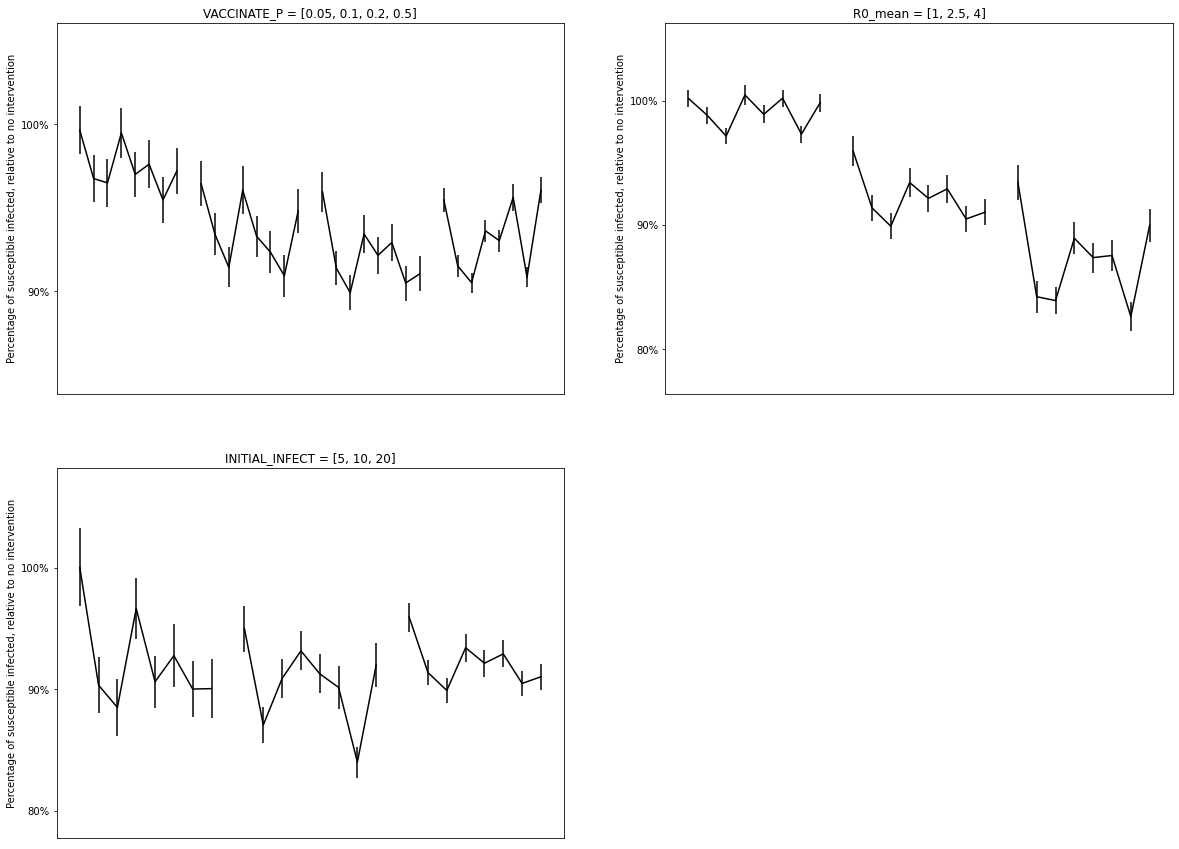

# HS2

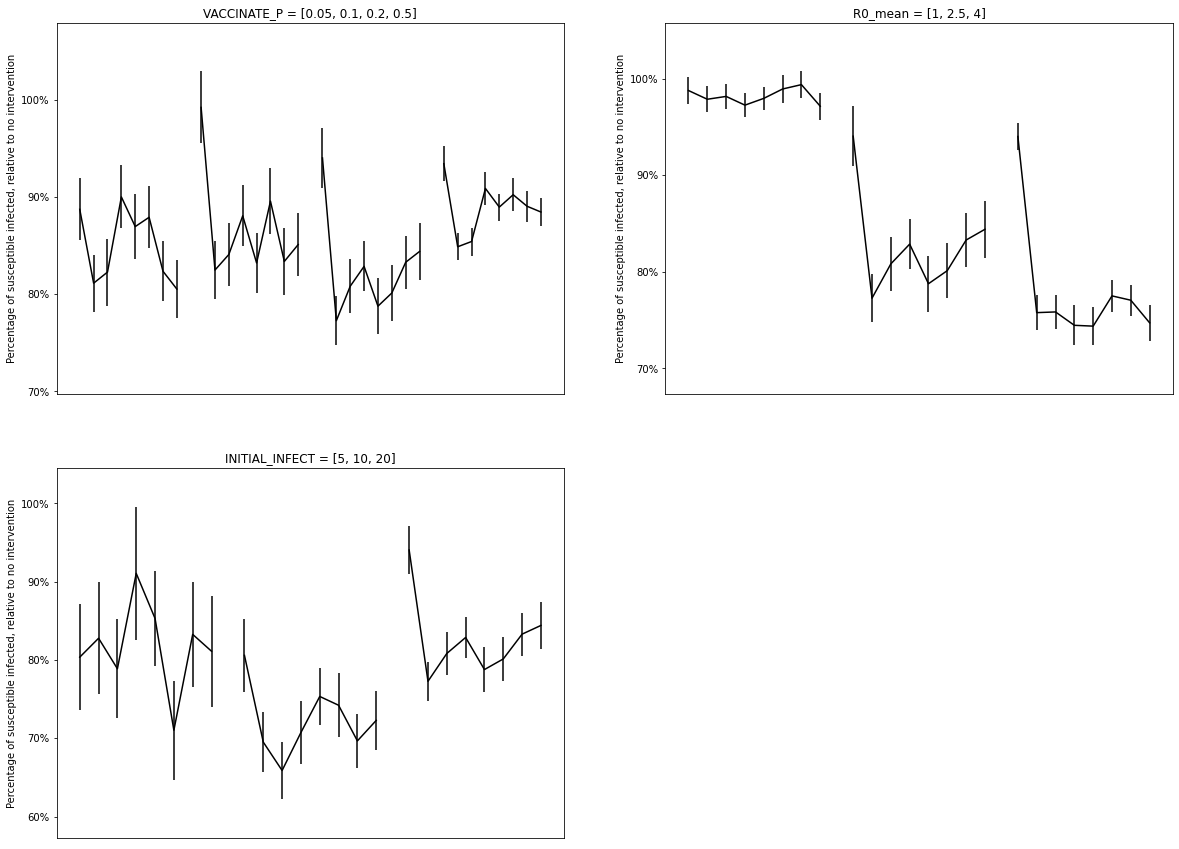

# synthetic_3

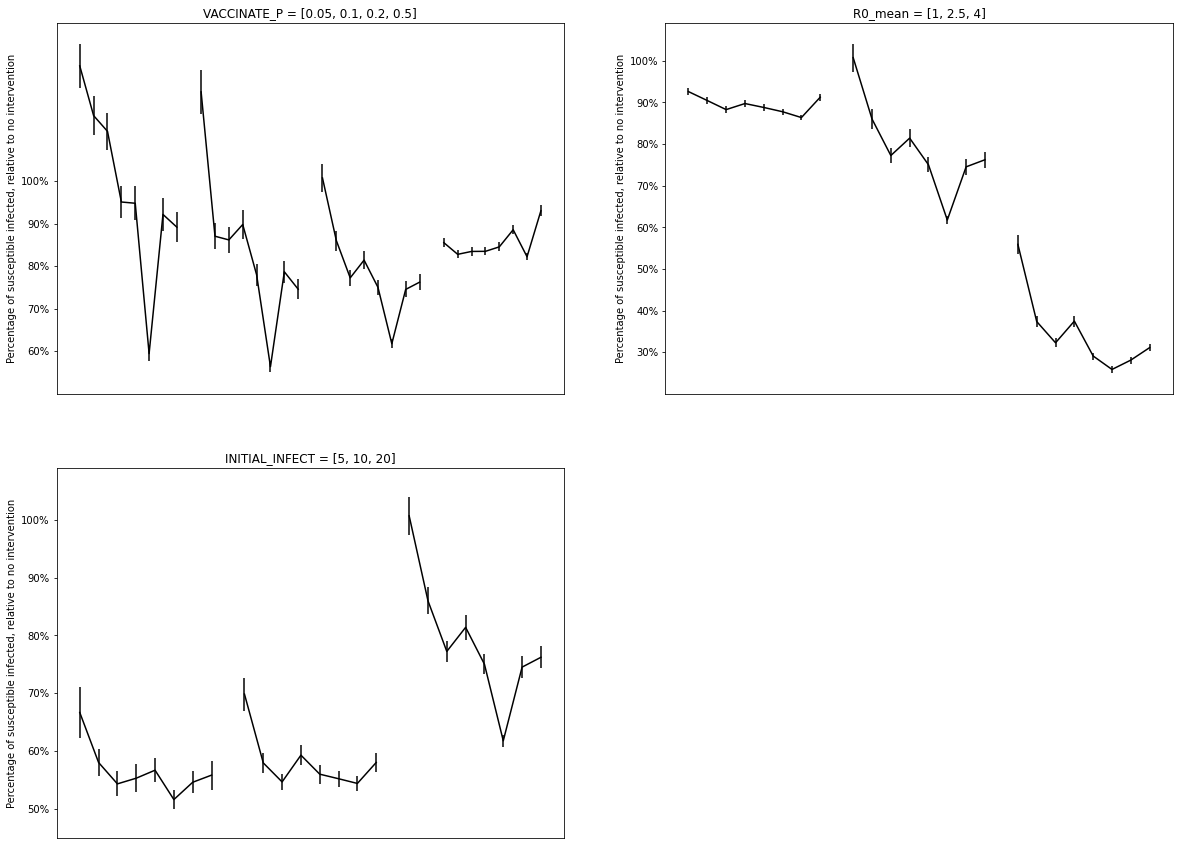

In [40]:
for ni, name in enumerate(names):
    sim_m = modelsets[name]
    df = dfs[name]
    
    display(Markdown(f"# {name}"))

    plt.figure(figsize=(20,15))

    for ci,comp in enumerate(comparisons):
        plt.subplot(2,2,ci+1)
        
        allvs = []
        for Vi,V in enumerate(comparisons[comp]):

            svals = []
            for s in strats:
                d = dict(defaults)
                d[comp] = V
                d['strat'] = s

                inf = sim_m.info( fzd( d ) )
                #print(inf['mean'], [x['mean'] for x in svals])

                svals.append(inf)


            #[s['N']s['mean'] for s in svals]

            xs = np.linspace(0,0.8,len(svals)) + Vi
            ys = np.array([ s['P_sus_inf_rel_rand'] for s in svals ])

            #plt.scatter(xs,ys)
            
            yerrs = np.array([s['P_sus_inf_rel_rand_err'] for s in svals ],)

            plt.errorbar(
                xs, ys,
                yerr = yerrs,
                color='black'
            )
            #print([s['min'] for s in svals])
            
            allvs.append( np.min(ys-yerrs)-0.05 )
            allvs.append( np.max(ys+yerrs)+0.05 )

        plt.title(f'{comp} = {comparisons[comp]}')
        
        ytk = np.linspace(0,1.0,11)
        plt.yticks(ytk, [f'{t:0.0%}' for t in ytk])
        plt.ylabel('Percentage of susceptible infected, relative to no intervention')
        plt.ylim( min(allvs),max(allvs) )
        
        plt.xticks([],[])
        
    plt.show()

# HS1_expand300

TypeError: 'simulation_manager' object is not subscriptable

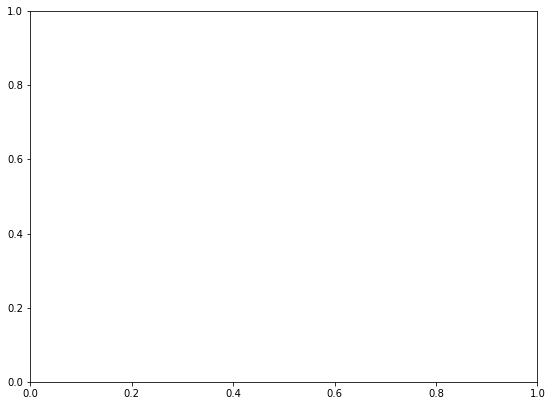

In [42]:
for ni, name in enumerate(names):
    models = modelsets[name]
    df = dfs[name]
    
    display(Markdown(f"# {name}"))

    plt.figure(figsize=(20,15))

    for ci,comp in enumerate(comparisons):
        plt.subplot(2,2,ci+1)
        
        allvs = []
        for Vi,V in enumerate(comparisons[comp]):

            svals = []
            for s in strats:
                d = dict(defaults)
                d[comp] = V
                d['strat'] = s

                inf = info( fzd( d ) )
                #print(inf['mean'], [x['mean'] for x in svals])

                svals.append(inf)


            #[s['N']s['mean'] for s in svals]

            xs = np.linspace(0,0.8,len(svals)) + Vi
            ys = np.array([ s['P_sus_inf_rel_none'] for s in svals ])

            #plt.scatter(xs,ys)
            
            yerrs = np.array([s['P_sus_inf_rel_none_err'] for s in svals ],)

            plt.bar(
                xs, ys,
                yerr = yerrs,
                color='grey',
                linewidth=1,
                edgecolor='black',
                capsize=3,
                width= 0.8*0.8 / len(svals)
            )
            #print([s['min'] for s in svals])
            
            allvs.append( np.min(ys-yerrs)-0.05 )
            allvs.append( np.max(ys+yerrs)+0.05 )

        plt.title(f'{comp} = {comparisons[comp]}')
        
        ytk = np.linspace(0,1.0,11)
        plt.yticks(ytk, [f'{t:0.0%}' for t in ytk])
        plt.ylabel('Percentage of susceptible infected, relative to no intervention')
        plt.ylim( min(allvs),max(allvs) )
        
        plt.xticks([],[])
        
    plt.show()

# HS1_expand300

TypeError: 'simulation_manager' object is not subscriptable

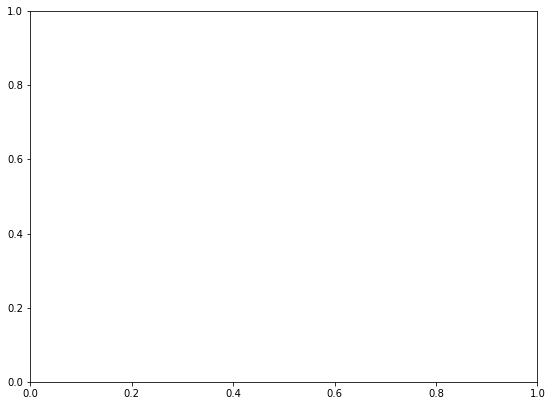

In [43]:
for ni, name in enumerate(names):
    models = modelsets[name]
    df = dfs[name]
    
    display(Markdown(f"# {name}"))

    plt.figure(figsize=(20,15))

    for ci,comp in enumerate(comparisons):
        plt.subplot(2,2,ci+1)
        for Vi,V in enumerate(comparisons[comp]):

            svals = []
            for s in strats:
                d = dict(defaults)
                d[comp] = V
                d['strat'] = s

                inf = info( fzd( d ) )
                #print(inf['mean'], [x['mean'] for x in svals])

                svals.append(inf)


            #[s['N']s['mean'] for s in svals]

            xs = np.linspace(0,0.8,len(svals)) + Vi
            
            ys = [ s['50p'] for s in svals ]

            #plt.scatter(xs,ys)
            
            for Q in ['25', '50', '75']:

                ln = []
                for xi in range(len(xs)):
                    s = svals[xi]
                    plt.plot( [ xs[xi], xs[xi] ], [ s[f'{Q}pL95'] / s['init_sus'], s[f'{Q}pH95'] / s['init_sus'] ], color='black' )
                    ln.append(s[f'{Q}p'] / s['init_sus'])

                plt.plot( xs, ln, color='black' )
                
            #print([s['min'] for s in svals])

        plt.title(f'{comp} = {comparisons[comp]}')
        #plt.ylim(0,1)
        #ytk = np.linspace(0,1.0,11)
        #plt.yticks(ytk, [f'{t:0.0%}' for t in ytk])
        #plt.ylabel('Percentage of susceptible infected, relative to no intervention')
        plt.xticks([],[])
        
    plt.show()

In [ ]:
#from simulation_manager import simulation_manager
#manager = simulation_manager()
#manager.load_models('HS1')

In [ ]:
lim = df[ (df['R0_mean'] == 2.5)&(df['INITIAL_INFECT']==20)&(df['VACCINATE_P']==0.20)&(df['strat']!='none')&(df['strat']!='rand') ]

In [41]:
import matplotlib
matplotlib.style.use('ggplot')

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

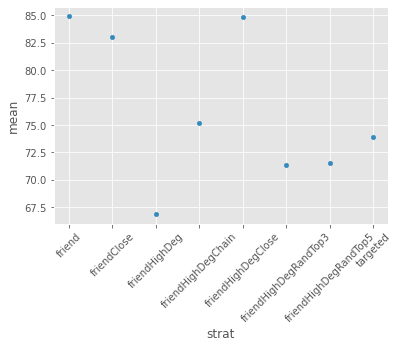

In [42]:
lim.plot(x='strat', y='mean', kind='scatter')
plt.xticks(rotation=45)

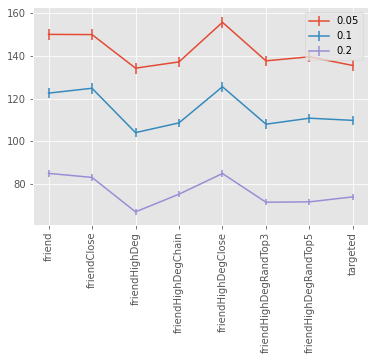

In [48]:
for vacc in [0.05, 0.10, 0.20]:
    lim = df[ (df['R0_mean'] == 2.5)&(df['INITIAL_INFECT']==20)&(df['VACCINATE_P']==vacc)&(df['strat']!='none')&(df['strat']!='rand') ]
    plt.errorbar(lim.strat, lim['mean'], yerr=lim['stderr'], label=vacc)
    plt.xticks(rotation=90)
    
plt.legend()

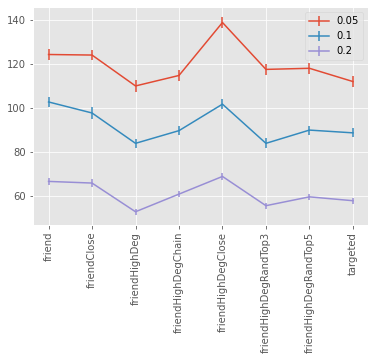

In [62]:
for vacc in [0.05, 0.10, 0.20]:
    lim = df[ (df['R0_mean'] == 2.5)&(df['INITIAL_INFECT']==20)&(df['VACCINATE_P']==vacc)&(df['strat']!='none')&(df['strat']!='rand') ]
    plt.errorbar(lim.strat, lim['25p'], yerr=lim['stderr'], label=vacc)
    plt.xticks(rotation=90)
    
plt.legend()

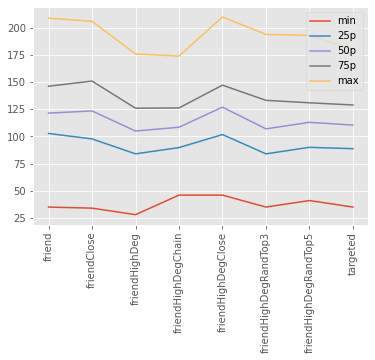

In [72]:
lim = df[ (df['R0_mean'] == 2.5)&(df['INITIAL_INFECT']==20)&(df['VACCINATE_P']==0.10)&(df['strat']!='none')&(df['strat']!='rand') ]
#plt.errorbar(lim.strat, lim['25p'], yerr=lim['stderr'], label=vacc)
for lab in ['min', '25p', '50p', '75p', 'max']:
    plt.plot(lim['strat'], lim[lab], label=lab)
plt.xticks(rotation=90)
    
plt.legend()

In [12]:
from simulation_helper import *

In [14]:
[x[0] for x in argset1]

[frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friend'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friend'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friend'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friendClose'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friendClose'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friendClose'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5, 'strat': 'friendClose'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friendHighDeg'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friendHighDeg'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean

In [5]:
ks = list(models)

In [6]:
Nsims = max(len(v) for v in models.values())
if not np.std([len(v) for v in models.values()]) < 1e-10:
    print("Warning, not all simulations are the same Ns")
print(f"Nsims_max = {Nsims}")

Nsims_max = 200


In [7]:
means, stds = {}, {}
for k in ks:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    stds[k] = np.std( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )

In [8]:
list(means)[:3]

[frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.05, 'strat': 'friend'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.1, 'strat': 'friend'}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.2, 'strat': 'friend'})]

In [9]:
len(means)

80

In [10]:
for kk in ['VACCINATE_P','strat','INITIAL_INFECT','R0_mean']:
    print( kk, set(x[kk] for x in means) )

VACCINATE_P {0.05, 0.5, 0.1, 0.2}
strat {'friend', 'rand', 'friendClose', 'none', 'friendHighDegRandTop3', 'friendHighDegChain', 'friendHighDegRandTop5', 'friendHighDegClose', 'targeted', 'friendHighDeg'}
INITIAL_INFECT {10, 20, 5}
R0_mean {1, 2.5, 4}


In [11]:
add_args = {'VACCINATE_P':0.20, 'INITIAL_INFECT':20, 'R0_mean':2.5}

k1 = fzd({'strat':'friendHighDeg', **add_args})
k2 = fzd({'strat':'rand', **add_args})
k3 = fzd({'strat':'targetted', **add_args})

print(f"Main effect. {k1}: {means[k1]:0.1f} vs. {k2}: {means[k2]:0.1f}")
print(f"\t or, a {(means[k1] - means[k2])/means[k2]:0.1%} INCREASE")

Main effect. frozendict({'strat': 'friendHighDeg', 'VACCINATE_P': 0.2, 'INITIAL_INFECT': 20, 'R0_mean': 2.5}): 66.9 vs. frozendict({'strat': 'rand', 'VACCINATE_P': 0.2, 'INITIAL_INFECT': 20, 'R0_mean': 2.5}): 92.5
	 or, a -27.7% INCREASE


In [12]:
add_args

{'VACCINATE_P': 0.2, 'INITIAL_INFECT': 20, 'R0_mean': 2.5}

In [13]:
# https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers
shapes = ['o', 'v', 's', 'P', 'D', 'x']

In [14]:
ks = [
    'friendHighDeg',
    #'rand',
    'targeted'
]

ks = sorted(set(x['strat'] for x in means))

In [15]:
add_arg_sets = set()
for x in means.keys():
    add_arg_sets.add( fzd( [y for y in x.items() if y[0] != 'strat'] ) )

In [16]:
ks.remove('none')

In [17]:
ks.remove('rand')

In [18]:
list(add_arg_sets)[:3]

[frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5}),
 frozendict({'INITIAL_INFECT': 5, 'R0_mean': 2.5, 'VACCINATE_P': 0.2}),
 frozendict({'INITIAL_INFECT': 20, 'R0_mean': 1, 'VACCINATE_P': 0.2})]

In [19]:
if False:
    add_arg_sets = [
        (f'vacc={v:0.2f}',
         f'inf={inf:d}')
        for inf in [5,10,20]
        for v in [0.05,0.10,0.20,0.50]
    ]
    #sorted(add_arg_sets)

In [20]:
k_map = {'friend':'NR', 'friendHighDeg': 'NP', 'friendHighDegChain': 'NP(c)', 'targeted': 'D',
        'friendHighDegRandTop5': 'NP.5', 'friendHighDegRandTop3': 'NP.3', 'friendClose': 'NC', 'friendHighDegClose': 'NPC', 'none': 'none', 'rand':'rand'}

In [21]:
param_map = {'INITIAL_INFECT': 'inf', 'R0_mean': 'R0', 'VACCINATE_P':'vacc'}

(0.3, 1.0)

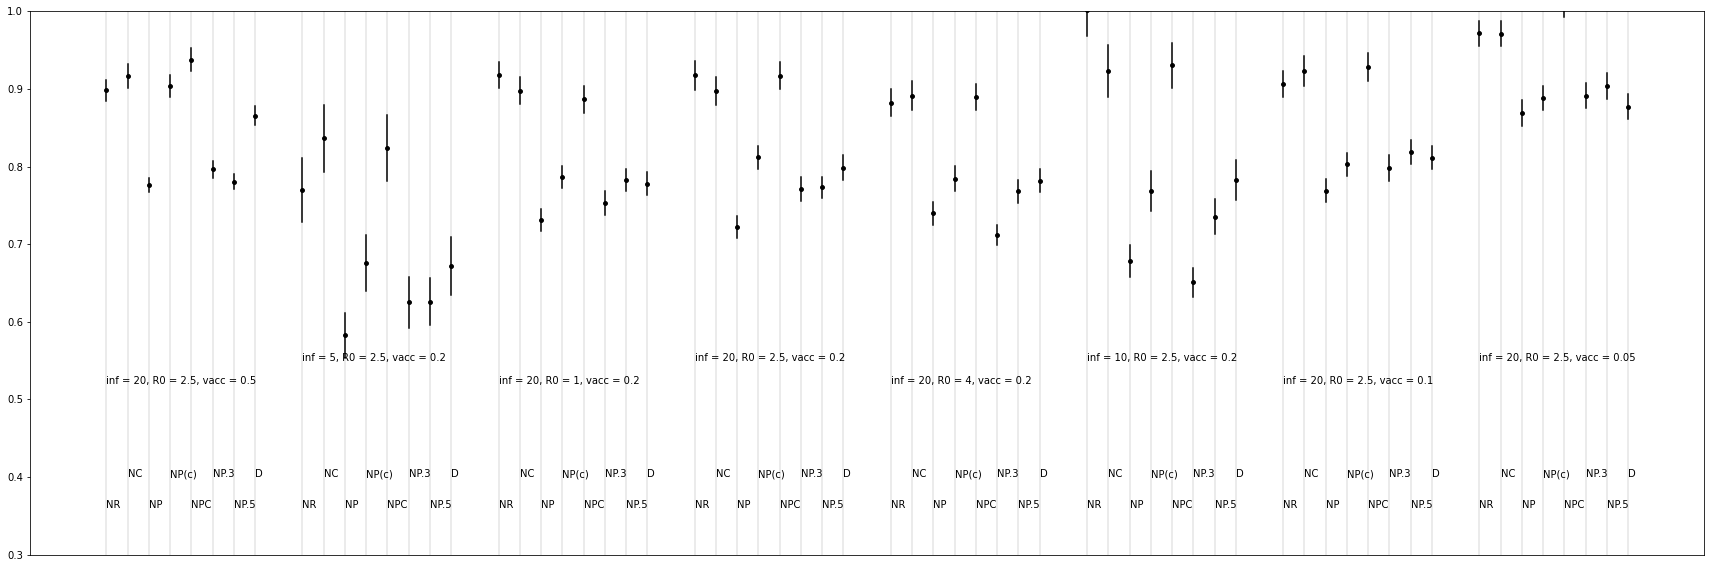

In [22]:
plt.figure(figsize=(30,10))
for ki, kpart in enumerate(ks):
    
    ais, avals, aerrs = [],[],[]
    for ai, add_args in enumerate(add_arg_sets):
        my_k = fzd({'strat':kpart, **add_args})
        rand_k = fzd({'strat':'rand', **add_args})
        
        myval = means[my_k] / means[rand_k]
        avals.append(myval)
        
        myerr = (stds[my_k]/np.sqrt(Nsims)) / means[rand_k]
        #myerr = np.mean( [ (m['numNodes'] - m['numS'])[-1] / ( (models[rand_k][mi]['numNodes'] - models[rand_k][mi]['numS'])[-1] ) for mi,m in enumerate(models[my_k]) ]  )
        aerrs.append( myerr )
        my_x =  ai*1.2 + ki*0.13
        
        plt.plot( [my_x,my_x], [myval-myerr, myval+myerr], color='black' )
        plt.plot( [my_x,my_x], [0,1], color='black', linestyle='-', alpha=0.1 )
        
        plt.text( my_x, 0.4 - 0.04 * (ki%2==0), k_map[kpart] )
        
        ais.append(my_x)
    
    #plt.scatter( ais, avals, marker=shapes[ki], label=kpart )
    plt.scatter( ais, avals, color='black', s=15 )
    
    #plt.plot( ais, avals, marker=shapes[ki], label=kpart )
    
    #plt.xticks(range(len(add_args)), add_args, rotation='90')
    #plt.xlim(0, len(add_args))
        
    #print(f"Main effect. {k1}: {means[k1]:0.1f} vs. {k2}: {means[k2]:0.1f}")
    #print(f"\t or, a {(means[k1] - means[k2])/means[k2]:0.1%} INCREASE")
    
for ai, add_args in enumerate(add_arg_sets):
    val = ", ".join([
        f"{param_map[k]} = {v}"
        for k,v in add_args.items()
    ])
    plt.text( ai*1.2, 0.55 - 0.03 * (ai%2==0) , val )
#plt.legend()

plt.xticks([],[]);
plt.ylim(0.3,1)

In [23]:
from simulation_helper import *

In [ ]:
plt.xl

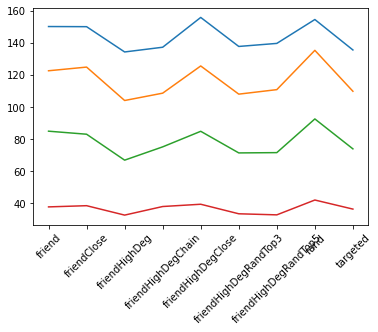

In [55]:
for vacc in [0.05, 0.10, 0.20, 0.50]:
    strats = [x[0]['strat'] for x in argset1 if x[0]['VACCINATE_P'] == vacc]
    plt.plot(
        strats,
        [means[x[0]] for x in argset1 if x[0]['VACCINATE_P'] == vacc]
    )
    plt.xticks(strats, strats, rotation=45)

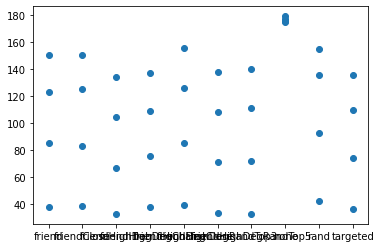

In [36]:


plt.scatter(
    [x[0]['strat'] for x in argset1],
    [means[x[0]] for x in argset1]
)

In [32]:
all([x[0] in models for x in argset1])

True

# count orderings

In [266]:
modelsets.keys()

dict_keys(['HS1_expand300', 'HS2', 'synthetic_3'])

In [276]:
for mname, models in modelsets.items():

    list(models)[0]

    means, stds = {}, {}
    for k in models:
        means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
        stds[k] = np.std( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )

    add_arg_sets = set()
    for x in models.keys():
        add_arg_sets.add( fzd( [y for y in x.items() if y[0] != 'strat'] ) )
    len(add_arg_sets)

    ks = sorted(set(x['strat'] for x in means))
    len(ks)

    count_them = []
    instances = defaultdict(list)

    for ai, add_args in enumerate(add_arg_sets):

        kvals = []
        for ki, kpart in enumerate(ks):
            my_k = fzd({'strat':kpart, **add_args})
            kvals.append( means[my_k] )

        order = tuple(np.argsort(kvals))

        for N1 in range(len(order)):
            for N2 in range(N1+1, len(order)):
                oid = (order[N1],order[N2])
                count_them.append(oid)

                instances[oid].append( add_args )

        #count_them.append(order)

    display(Markdown(f"# {mname}"))

    for (o1,o2), c in Counter(count_them).most_common(25):
        oid1 = (o1, o2)
        oid2 = (o2, o1)

        print(f"{c}/{len(add_arg_sets)}. {ks[o1]} [better than] {ks[o2]}")
        if len(instances[oid2]):
            print("\tExceptions:")
            for exc in instances[oid2]:
                print(f"\t\t{exc}")

# HS1_expand300

8/8. friendHighDegRandTop3 [better than] friendHighDegChain
8/8. friendHighDegRandTop3 [better than] friendHighDegNormalErr10
8/8. friendHighDegRandTop3 [better than] friendHighDegNormalErr20
8/8. friendHighDegRandTop3 [better than] rand
8/8. friendHighDegRandTop3 [better than] friend
8/8. friendHighDegRandTop3 [better than] none
8/8. friendHighDeg [better than] friendHighDegChain
8/8. friendHighDeg [better than] friendHighDegRandTop5
8/8. friendHighDeg [better than] friendHighDegNormalErr10
8/8. friendHighDeg [better than] targeted
8/8. friendHighDeg [better than] friendHighDegNormalErr20
8/8. friendHighDeg [better than] rand
8/8. friendHighDeg [better than] friend
8/8. friendHighDeg [better than] none
8/8. friendHighDegChain [better than] rand
8/8. friendHighDegChain [better than] none
8/8. friendHighDegRandTop5 [better than] friendHighDegNormalErr20
8/8. friendHighDegRandTop5 [better than] rand
8/8. friendHighDegRandTop5 [better than] friend
8/8. friendHighDegRandTop5 [better than] 

# HS2

8/8. targeted [better than] rand
8/8. targeted [better than] none
8/8. friendHighDegChain [better than] rand
8/8. friendHighDegChain [better than] none
8/8. friend [better than] rand
8/8. friend [better than] none
8/8. friendHighDegRandTop3 [better than] rand
8/8. friendHighDegRandTop3 [better than] none
8/8. friendHighDegNormalErr10 [better than] rand
8/8. friendHighDegNormalErr10 [better than] none
8/8. friendHighDegNormalErr20 [better than] rand
8/8. friendHighDegNormalErr20 [better than] none
8/8. friendHighDegRandTop5 [better than] rand
8/8. friendHighDegRandTop5 [better than] none
8/8. friendHighDeg [better than] rand
8/8. friendHighDeg [better than] none
8/8. rand [better than] none
7/8. targeted [better than] friend
	Exceptions:
		frozendict({'INITIAL_INFECT': 20, 'R0_mean': 1, 'VACCINATE_P': 0.2})
7/8. friendHighDegChain [better than] friend
	Exceptions:
		frozendict({'INITIAL_INFECT': 20, 'R0_mean': 1, 'VACCINATE_P': 0.2})
7/8. friendHighDegRandTop3 [better than] friendHighDe

# synthetic_3

8/8. targeted [better than] friendHighDegChain
8/8. targeted [better than] rand
8/8. targeted [better than] none
8/8. friendHighDegNormalErr20 [better than] friend
8/8. friendHighDegNormalErr20 [better than] none
8/8. friendHighDeg [better than] friendHighDegRandTop3
8/8. friendHighDeg [better than] friendHighDegRandTop5
8/8. friendHighDeg [better than] friend
8/8. friendHighDeg [better than] none
8/8. friendHighDegRandTop3 [better than] friendHighDegRandTop5
8/8. friendHighDegRandTop3 [better than] friend
8/8. friendHighDegRandTop3 [better than] none
8/8. friendHighDegChain [better than] none
8/8. friendHighDegRandTop5 [better than] friend
8/8. friendHighDegRandTop5 [better than] none
8/8. friendHighDegNormalErr10 [better than] friend
8/8. friendHighDegNormalErr10 [better than] none
8/8. friend [better than] none
8/8. rand [better than] none
7/8. targeted [better than] friendHighDegNormalErr20
	Exceptions:
		frozendict({'INITIAL_INFECT': 20, 'R0_mean': 2.5, 'VACCINATE_P': 0.5})
7/8. t

# other stuff?

In [176]:
ks = [
    'friendHighDeg',
    'targeted',
    'friend',
    'friendHighDegChain',
    #'friendHighDegRandTop3',
    #'friendHighDegRandTop5',
]

In [167]:
k_map = {
    'friend':'NR', 
    'friendHighDeg': 'NP', 
    'friendHighDegChain': 'NP(c)', 
    'targeted': 'D',
    'friendHighDegRandTop3': 'NP.3',
    'friendHighDegRandTop5': 'NP.5',
}

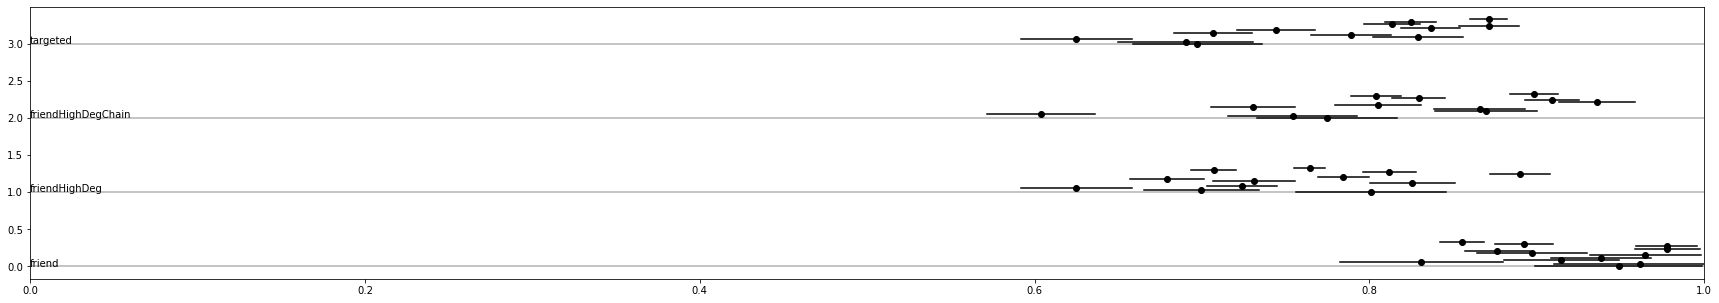

In [164]:
plt.figure(figsize=(30,5))
for ki, kpart in enumerate(ks):
    
    #plt.subplot(1,4,ki+1)
    
    plt.plot([0,1],[ki]*2, color='black', alpha=0.3)
    plt.text(0,ki, kpart, color='black')
    
    ais, avals, aerrs = [],[],[]
    for ai, add_args in enumerate(add_arg_sets):
        my_k = (kpart, *add_args)
        rand_k = ('rand', *add_args)
        
        myval = means[my_k] / means[rand_k]
        avals.append(myval)
        
        myerr = (stds[my_k]/np.sqrt(Nsims)) / means[rand_k]
        aerrs.append( myerr )
        
        YY = ki+ai*0.03
        plt.plot( [myval-myerr, myval+myerr], [YY]*2, color='black' )
        plt.scatter( [myval], [YY]*1, color='black' )
        
    
        
    #plt.hist(avals, bins=10)
    plt.xlim(0,1)
    #plt.title(kpart)

In [169]:
def get_result(x):
    return (x['numNodes'] - x['numS'])[-1]

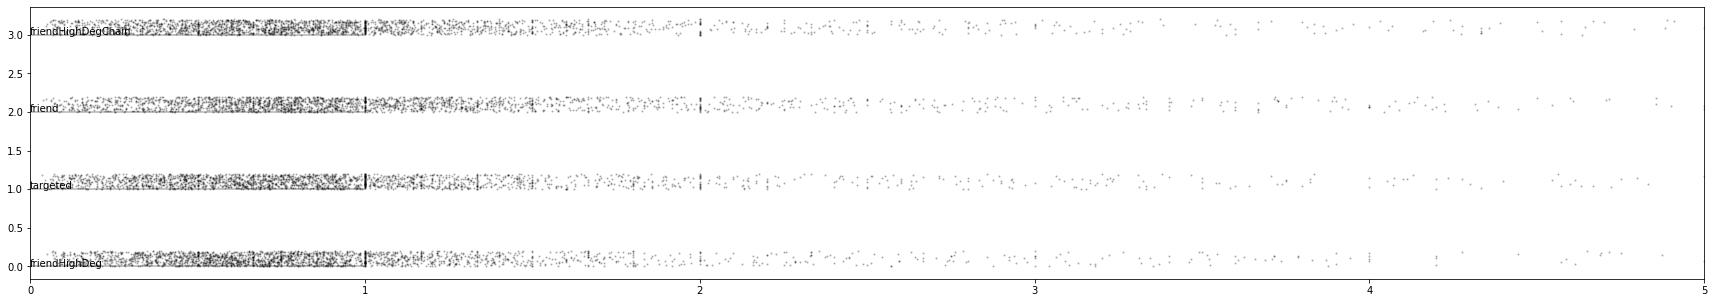

In [195]:
plt.figure(figsize=(30,5))
for ki, kpart in enumerate(ks):
    
    #plt.subplot(1,4,ki+1)
    
    plt.plot([0,1],[ki]*2, color='black', alpha=0.3)
    plt.text(0,ki, kpart, color='black')
    
    ais, avals, aerrs = [],[],[]
    for ai, add_args in enumerate(add_arg_sets):
        my_k = (kpart, *add_args)
        rand_k = ('rand', *add_args)
        
        myvals = [ get_result(models[my_k][mi]) / get_result(models[rand_k][mi]) for mi in range( min(len(models[rand_k]), len(models[my_k])) ) ]
        #avals.append(myval)
        
        #myerr = (stds[my_k]/np.sqrt(Nsims)) / means[rand_k]
        #aerrs.append( myerr )
        
        YY = [ ki+random()*0.2 for _ in range(len(myvals)) ]
        #plt.plot( [myval-myerr, myval+myerr], [YY]*2, color='black' )
        #plt.scatter( myvals, [YY]*len(myvals), color='black', s=1.5 )
        plt.scatter( myvals, YY, color='black', s=1.5, alpha=0.2 )
        
    
        
    #plt.hist(avals, bins=10)
    plt.xlim(0,5)
    #plt.title(kpart)

([], [])

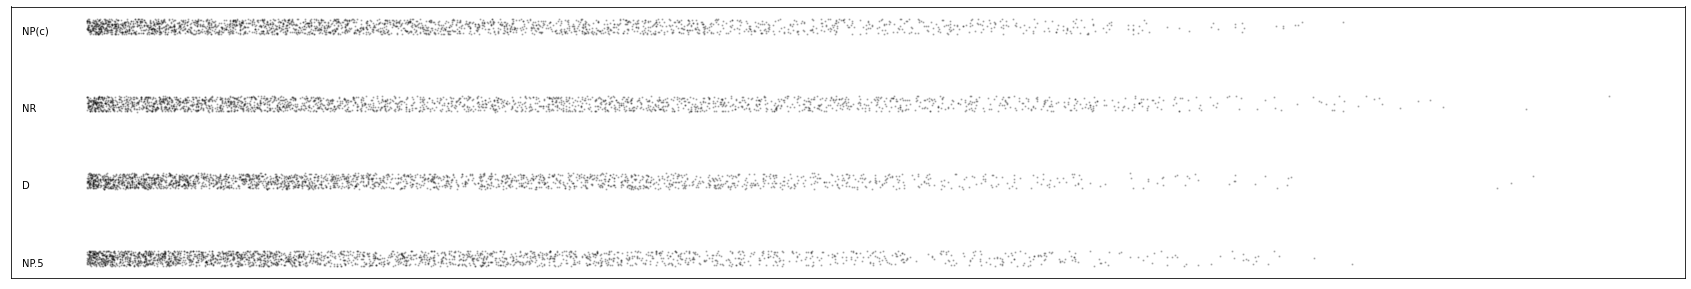

In [204]:
plt.figure(figsize=(30,5))
for ki, kpart in enumerate(ks):
    
    #plt.subplot(1,4,ki+1)
    
    #plt.xticks([],[])plt.plot([0,1],[ki]*2, color='black', alpha=0.3)
    plt.text(-5,ki, k_map[kpart], color='black')
    
    ais, avals, aerrs = [],[],[]
    for ai, add_args in enumerate(add_arg_sets):
        my_k = (kpart, *add_args)
        rand_k = ('rand', *add_args)
        
        myvals = [ get_result(models[my_k][mi])+random() for mi in range( min(len(models[rand_k]), len(models[my_k])) ) ]
        #avals.append(myval)
        
        #myerr = (stds[my_k]/np.sqrt(Nsims)) / means[rand_k]
        #aerrs.append( myerr )
        
        YY = [ ki+random()*0.2 for _ in range(len(myvals)) ]
        #plt.plot( [myval-myerr, myval+myerr], [YY]*2, color='black' )
        #plt.scatter( myvals, [YY]*len(myvals), color='black', s=1.5 )
        plt.scatter( myvals, YY, color='black', s=1.5, alpha=0.2 )
        
    
        
    #plt.hist(avals, bins=10)
    #plt.xlim(0,1)
    #plt.title(kpart)
plt.xticks([],[])
plt.yticks([],[])

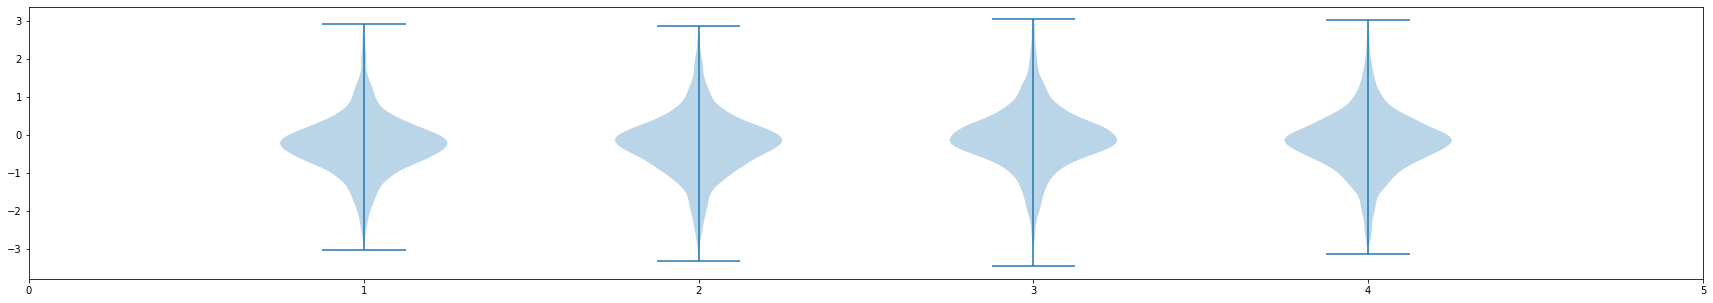

In [183]:
aval_sets = []

plt.figure(figsize=(30,5))
for ki, kpart in enumerate(ks):
    
    #plt.subplot(1,4,ki+1)
    
    #plt.plot([0,1],[ki]*2, color='black', alpha=0.3)
    #plt.text(0,ki, kpart, color='black')
    
    ais, avals, aerrs = [],[],[]
    
    for ai, add_args in enumerate(add_arg_sets):
        my_k = (kpart, *add_args)
        rand_k = ('rand', *add_args)
        
        myvals = [ get_result(models[my_k][mi]) / get_result(models[rand_k][mi]) for mi in range( min(len(models[rand_k]), len(models[my_k])) ) ]
        myvals = np.array(myvals)
        myvals = np.log(myvals)
        #avals.append(myval)
        
        #myerr = (stds[my_k]/np.sqrt(Nsims)) / means[rand_k]
        #aerrs.append( myerr )
        
        YY = ki+ai*0.03
        #plt.plot( [myval-myerr, myval+myerr], [YY]*2, color='black' )
        #plt.scatter( myvals, [YY]*len(myvals), color='black', s=1.5 )
        #plt.scatter( myvals, [YY]*len(myvals), color='black', s=1.5 )
        avals += list(myvals)
        
    aval_sets.append(avals)
        
        
    #plt.hist(avals, bins=10)
plt.xlim(0,5)
plt.violinplot(aval_sets);

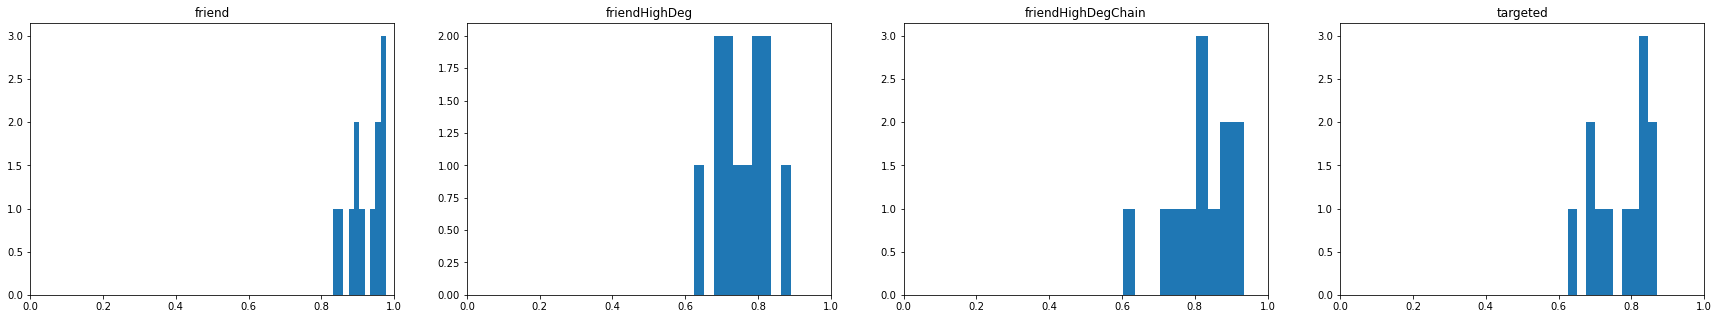

In [143]:
plt.figure(figsize=(30,5))
for ki, kpart in enumerate(ks):
    
    plt.subplot(1,4,ki+1)
    
    ais, avals, aerrs = [],[],[]
    for ai, add_args in enumerate(add_arg_sets):
        my_k = (kpart, *add_args)
        rand_k = ('rand', *add_args)
        
        myval = means[my_k] / means[rand_k]
        avals.append(myval)
        
    plt.hist(avals, bins=10)
    plt.xlim(0,1)
    plt.title(kpart)

In [7]:
for add_args in sorted(set( tuple(x[1:]) for x in ks )):
    
    print(add_args)

    #k1 = ('friendHighDeg', *add_args)
    k2 = ('rand', *add_args)
    k1 = ('targeted', *add_args)

    print(f"Main effect. {k1}: {means[k1]:0.1f} vs. {k2}: {means[k2]:0.1f}")
    print(f"\t or, a {(means[k1] - means[k2])/means[k2]:0.1%} INCREASE")
    
    print()

('vacc=0.05', 'inf=10')
Main effect. ('targeted', 'vacc=0.05', 'inf=10'): 79.6 vs. ('rand', 'vacc=0.05', 'inf=10'): 100.9
	 or, a -21.1% INCREASE

('vacc=0.05', 'inf=20')
Main effect. ('targeted', 'vacc=0.05', 'inf=20'): 121.5 vs. ('rand', 'vacc=0.05', 'inf=20'): 139.5
	 or, a -12.9% INCREASE

('vacc=0.05', 'inf=5')
Main effect. ('targeted', 'vacc=0.05', 'inf=5'): 41.1 vs. ('rand', 'vacc=0.05', 'inf=5'): 59.0
	 or, a -30.3% INCREASE

('vacc=0.10', 'inf=10')
Main effect. ('targeted', 'vacc=0.10', 'inf=10'): 59.2 vs. ('rand', 'vacc=0.10', 'inf=10'): 83.7
	 or, a -29.3% INCREASE

('vacc=0.10', 'inf=20')
Main effect. ('targeted', 'vacc=0.10', 'inf=20'): 96.1 vs. ('rand', 'vacc=0.10', 'inf=20'): 118.1
	 or, a -18.7% INCREASE

('vacc=0.10', 'inf=5')
Main effect. ('targeted', 'vacc=0.10', 'inf=5'): 31.5 vs. ('rand', 'vacc=0.10', 'inf=5'): 45.6
	 or, a -31.0% INCREASE

('vacc=0.20', 'inf=10')
Main effect. ('targeted', 'vacc=0.20', 'inf=10'): 40.3 vs. ('rand', 'vacc=0.20', 'inf=10'): 54.2
	 or,

In [9]:
for k in sorted(ks, key=lambda k:means[k]):
    m = means[k]
    print(f'{k}: {m:0.1f}')

('friendHighDeg', 'vacc=0.50', 'inf=5'): 8.1
('targeted', 'vacc=0.50', 'inf=5'): 9.3
('rand', 'vacc=0.50', 'inf=5'): 11.2
('friendHighDeg', 'vacc=0.50', 'inf=10'): 17.1
('targeted', 'vacc=0.50', 'inf=10'): 18.3
('friendHighDeg', 'vacc=0.20', 'inf=5'): 20.1
('targeted', 'vacc=0.20', 'inf=5'): 20.1
('rand', 'vacc=0.50', 'inf=10'): 21.8
('targeted', 'vacc=0.10', 'inf=5'): 31.5
('friendHighDeg', 'vacc=0.50', 'inf=20'): 31.7
('friendHighDeg', 'vacc=0.10', 'inf=5'): 31.9
('rand', 'vacc=0.20', 'inf=5'): 32.2
('targeted', 'vacc=0.50', 'inf=20'): 36.1
('friendHighDeg', 'vacc=0.20', 'inf=10'): 36.8
('targeted', 'vacc=0.20', 'inf=10'): 40.3
('targeted', 'vacc=0.05', 'inf=5'): 41.1
('rand', 'vacc=0.50', 'inf=20'): 41.4
('rand', 'vacc=0.10', 'inf=5'): 45.6
('friendHighDeg', 'vacc=0.05', 'inf=5'): 47.2
('rand', 'vacc=0.20', 'inf=10'): 54.2
('rand', 'vacc=0.05', 'inf=5'): 59.0
('targeted', 'vacc=0.10', 'inf=10'): 59.2
('friendHighDeg', 'vacc=0.10', 'inf=10'): 61.2
('friendHighDeg', 'vacc=0.20', 'inf=

In [10]:
for k in sorted(ks, key=lambda x:(x[2],x[1],x[0])):
    m = means[k]
    print(f'{means[k]:0.1f} +/- {stds[k]/np.sqrt(Nsims):0.1f}          \t{k}')

83.3 +/- 2.5          	('friendHighDeg', 'vacc=0.05', 'inf=10')
121.0 +/- 3.8          	('none', 'vacc=0.05', 'inf=10')
100.9 +/- 3.1          	('rand', 'vacc=0.05', 'inf=10')
79.6 +/- 2.4          	('targeted', 'vacc=0.05', 'inf=10')
61.2 +/- 2.0          	('friendHighDeg', 'vacc=0.10', 'inf=10')
122.7 +/- 3.7          	('none', 'vacc=0.10', 'inf=10')
83.7 +/- 2.7          	('rand', 'vacc=0.10', 'inf=10')
59.2 +/- 1.9          	('targeted', 'vacc=0.10', 'inf=10')
36.8 +/- 1.2          	('friendHighDeg', 'vacc=0.20', 'inf=10')
127.6 +/- 3.7          	('none', 'vacc=0.20', 'inf=10')
54.2 +/- 1.8          	('rand', 'vacc=0.20', 'inf=10')
40.3 +/- 1.3          	('targeted', 'vacc=0.20', 'inf=10')
17.1 +/- 0.3          	('friendHighDeg', 'vacc=0.50', 'inf=10')
116.1 +/- 3.4          	('none', 'vacc=0.50', 'inf=10')
21.8 +/- 0.6          	('rand', 'vacc=0.50', 'inf=10')
18.3 +/- 0.4          	('targeted', 'vacc=0.50', 'inf=10')
124.1 +/- 2.5          	('friendHighDeg', 'vacc=0.05', 'inf=20'

In [11]:
def get_N(m, t):
    latest = np.max( np.where( m['tseries'] <= t ) )
    return m['numNodes'] - m['numS'][latest]

Text(0.5, 1.0, 'friendHighDeg')

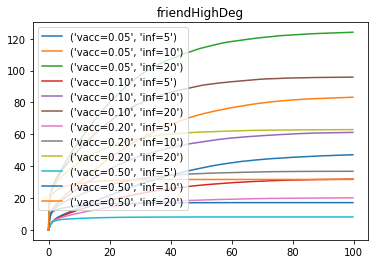

In [12]:
ts = np.arange(0,100, 0.2)
for k in models:
    if 'friendHighDeg' not in k:
        continue
    series = [np.mean( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k[1:] )
plt.legend();
plt.title('friendHighDeg')

(20.0, 60.0)

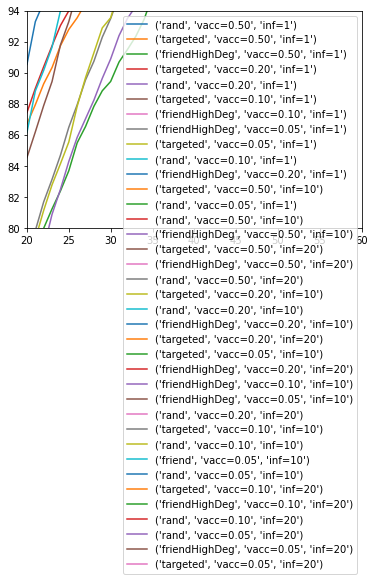

In [46]:
ts = np.arange(20,60, 1)

means = {}
for k in models:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    
for k in sorted(models, key=lambda x:means[x]):
    series = [np.mean( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
plt.legend();
plt.ylim(80,94)
plt.xlim(20,60)

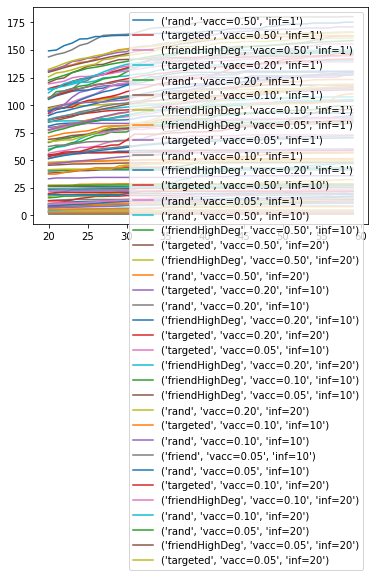

In [47]:
ts = np.arange(20,60, 1)

means = {}
for k in models:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    
QUANTILE = 0.75
    
for k in sorted(models, key=lambda x:means[x]):
    series = [np.mean( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
    
    smax = [np.quantile( [get_N(m, t) for m in models[k]], QUANTILE ) for t in ts]
    smin = [np.quantile( [get_N(m, t) for m in models[k]], 1-QUANTILE ) for t in ts]
    plt.plot(ts, smin)
    plt.plot(ts, smax)
    
plt.legend();
#plt.ylim(80,94)
#plt.xlim(20,60)

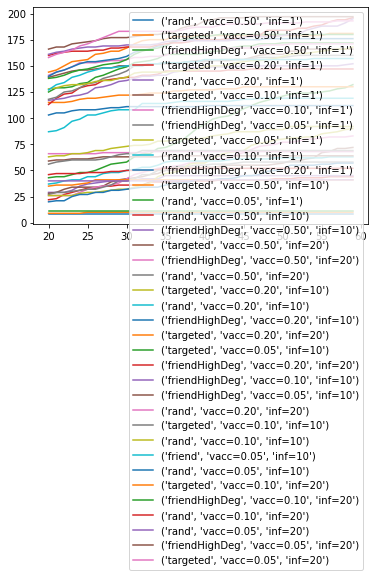

In [50]:
ts = np.arange(20,60, 1)

means = {}
for k in models:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    
for k in sorted(models, key=lambda x:means[x]):
    series = [np.max( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
plt.legend();
#plt.ylim(80,94)
#plt.xlim(20,60)

In [13]:
from scipy.stats import wilcoxon

In [14]:
wilcoxons = {}

for k1 in ks:
    for k2 in ks:
        if k1 == k2:
            val = np.nan
        else:
            val = wilcoxon( 
                [ (m['numNodes'] - m['numS'])[-1] for m in models[k1] ],
                [ (m['numNodes'] - m['numS'])[-1] for m in models[k2] ] 
            ).pvalue
        wilcoxons[(k1,k2)] = val

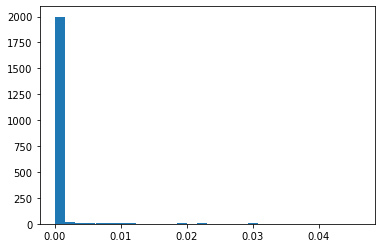

In [17]:
plt.hist( [x for x in wilcoxons.values() if x<0.05], bins=30 );

In [25]:
wilcox_mat = np.zeros((len(ks),len(ks)))

In [29]:
list(ks)[0]

('friendHighDeg', 'vacc=0.05', 'inf=10')

In [26]:
ksort = sorted(ks, key=lambda x:(x[2],x[1],x[0]))

In [27]:
for (k1,k2), val in wilcoxons.items():
    wilcox_mat[ 
        ksort.index(k1),
        ksort.index(k2)
    ] = val

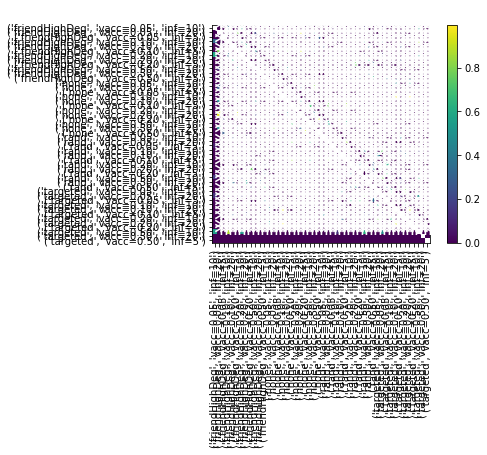

In [28]:
plt.imshow(wilcox_mat)
plt.xticks(range(len(ks)),ks,rotation='vertical')
plt.yticks(range(len(ks)),ks);
plt.colorbar();

for ki1 in range(len(ks)):
    for ki2 in range(len(ks)):
        if wilcox_mat[ki1,ki2] < 0.05:
            plt.text( ki1-0.25, ki2+0.5, "*", color='white', size=30 )

In [ ]:
ks = sorted(models, key=lambda x:means[x])

In [ ]:
ks.remove('none')

In [ ]:
ks

In [ ]:
stds

In [ ]:
plt.errorbar?

In [ ]:
marr = np.array([means[k] for k in ks])
sarr = np.array([stds[k] for k in ks])
N = len(models['none'])

plt.bar(
    ks,
    marr
)
plt.errorbar(
    ks,
    marr,
    yerr=sarr/np.sqrt(N),
    color='black'
)
plt.ylim(88,93)
plt.xticks(ks, rotation='vertical');

In [69]:
types = set([tuple(list(k)[1:]) for k in ks])

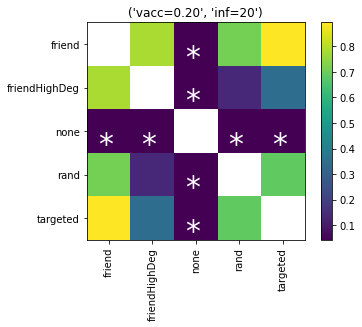

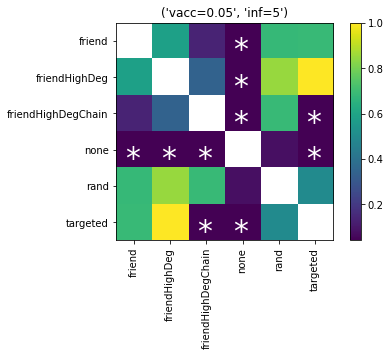

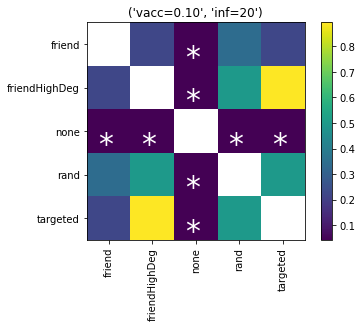

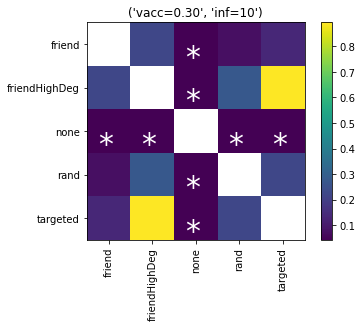

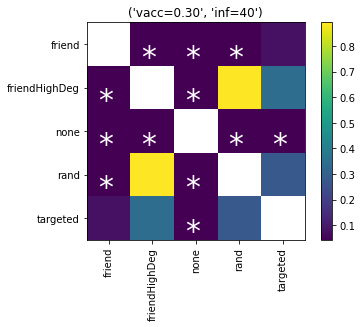

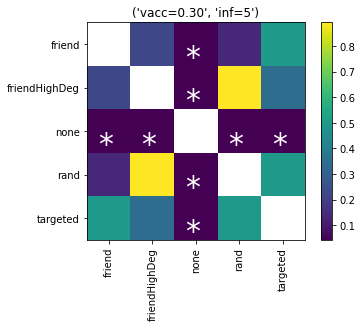

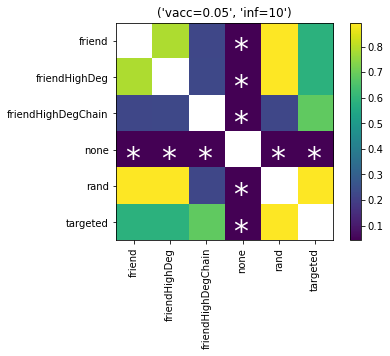

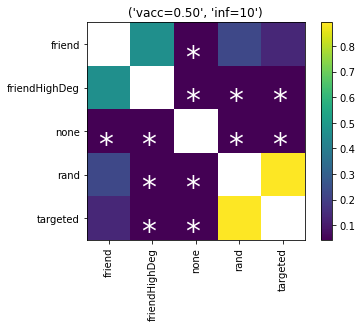

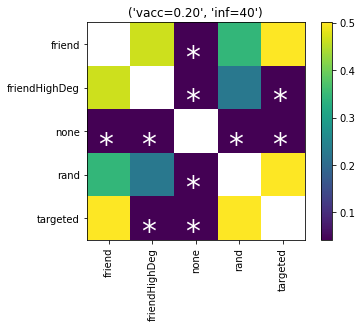

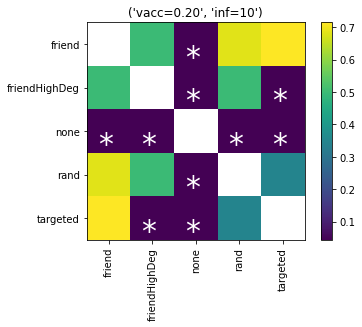

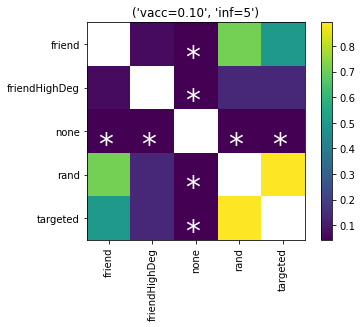

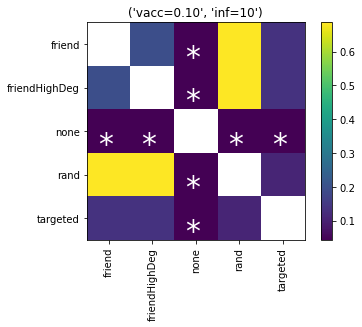

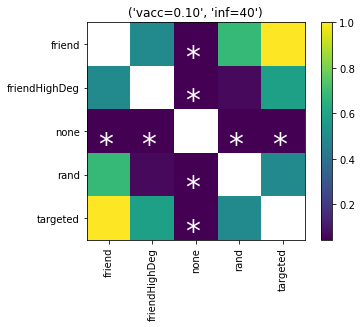

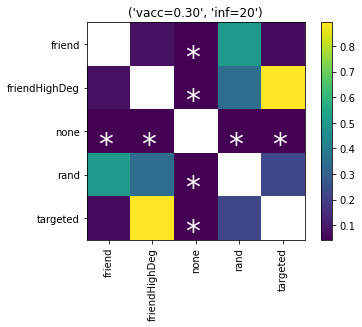

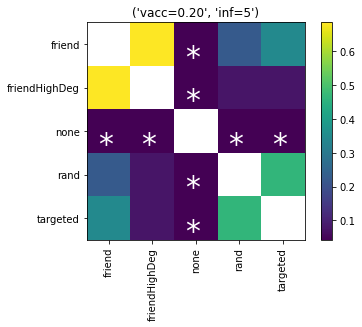

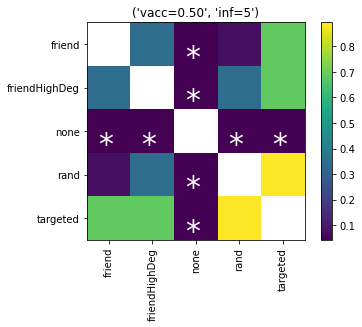

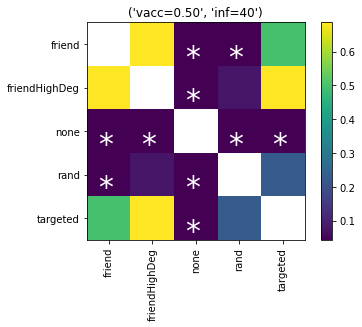

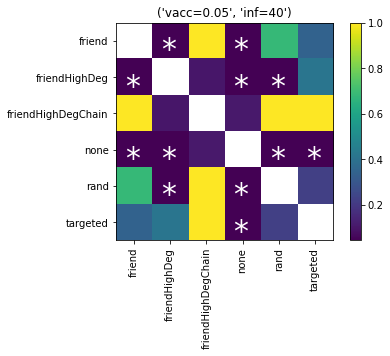

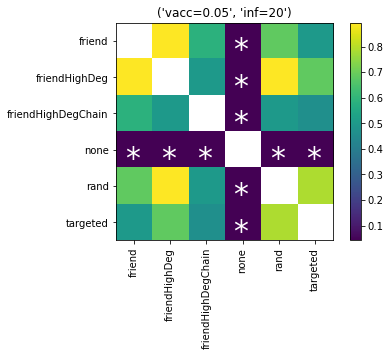

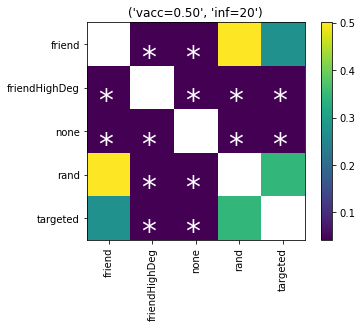

In [91]:
def istype(k, t):
    return tuple(list(k)[1:]) == t

from scipy.stats import wilcoxon

for t in types:

    wilcoxons = {}
    
    my_ks = set()

    for k1 in ks:
        if not istype(k1, t):
            continue
        my_ks.add(k1)
        for k2 in ks:
            if not istype(k2, t):
                continue
            if k1 == k2:
                val = np.nan
            else:
                arr1 = [ (m['numNodes'] - m['numS'])[-1] for m in models[k1] ]
                arr2 = [ (m['numNodes'] - m['numS'])[-1] for m in models[k2] ]
                
                if not len(arr1) or not len(arr2):
                    continue
                    
                newl = min(len(arr1), len(arr2))
                arr1 = arr1[:newl]
                arr2 = arr2[:newl]
                val = wilcoxon(arr1, arr2).pvalue
            wilcoxons[(k1,k2)] = val

    my_ks = sorted(my_ks)

    wilcox_mat = np.zeros((len(my_ks),len(my_ks)))

    for (k1,k2), val in wilcoxons.items():
        wilcox_mat[ 
            my_ks.index(k1),
            my_ks.index(k2)
        ] = val

    plt.imshow(wilcox_mat)
    plt.xticks(range(len(my_ks)),[x[0] for x in my_ks],rotation='vertical')
    plt.yticks(range(len(my_ks)),[x[0] for x in my_ks]);
    plt.colorbar();

    for ki1 in range(len(my_ks)):
        for ki2 in range(len(my_ks)):
            if wilcox_mat[ki1,ki2] < 0.05:
                plt.text( ki1-0.25, ki2+0.5, "*", color='white', size=30 )

    plt.title(t)
    plt.show()